In [15]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (roc_curve, precision_recall_curve,  
                            auc, make_scorer, recall_score, accuracy_score, 
                            precision_score, confusion_matrix)

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [43]:
#### read data
df = pd.read_csv('C:/MYDATA/data.csv')
#print(df.head())

#### we count freqs in 'diagnosis' column
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [44]:
#### PREPROCESS AND DIVIDE TRAIN-TEST SETS

#### binarize the target
lb = LabelBinarizer()
df['diagnosis'] = lb.fit_transform(df['diagnosis'].values)
#df.head()

#### we define the target
targets = df['diagnosis']
#df.head()
df.drop(['id', 'diagnosis', 'Unnamed: 32'], axis=1, inplace=True)
#df.head()

#### we divide sets
X_train, X_test, y_train, y_test = train_test_split(df, targets, stratify=targets)

In [50]:
# show the distribution
print('y_train class distribution')
print(y_train.value_counts())
print('y_test class distribution')
y_test.value_counts()

y_train class distribution
0    267
1    159
Name: diagnosis, dtype: int64
y_test class distribution


0    90
1    53
Name: diagnosis, dtype: int64

In [52]:
#### we build a grid to search parameters in a random-forest classifier
clf = RandomForestClassifier(n_jobs=-1)

#### we define data structure type dictionary to define hyperparameters and metrics
param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [54]:
#### function to fit the classifier with parameters in the grid and optimizing by precission
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search


grid_search_clf = grid_search_wrapper(refit_score='precision_score')

Best params for precision_score
{'max_depth': 5, 'max_features': 5, 'min_samples_split': 5, 'n_estimators': 100}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg        85         5
pos         3        50


In [55]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 
         'param_max_depth', 'param_max_features', 
         'param_min_samples_split', 'param_n_estimators']].round(3).head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators
32,0.969,0.925,0.960,5,5,5,100
5,0.968,0.912,0.955,3,3,10,300
1,0.968,0.906,0.953,3,3,3,300
27,0.964,0.937,0.962,5,3,5,300
72,0.964,0.931,0.960,25,3,3,100


In [59]:
####
#### tuning the classifier - ROC
####

#### we get probabilities of classifying in test set
y_scores = grid_search_clf.predict_proba(X_test)[:, 1]
p, r, thresholds = precision_recall_curve(y_test, y_scores)

In [60]:
#### function to define label with y_scores depends on threshold decision defined (t)
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]


#### function to plot precision and recall 
def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

     pred_neg  pred_pos
neg        83         7
pos         1        52


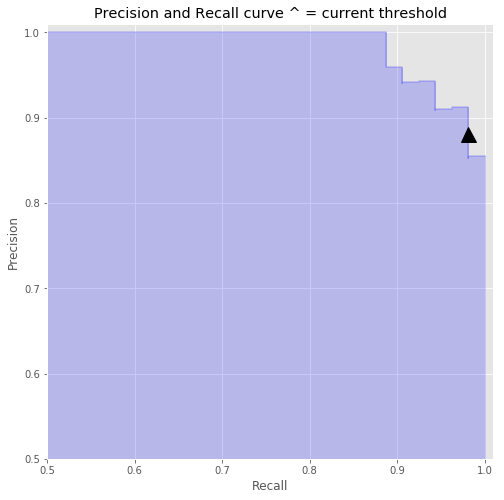

In [65]:
#### testing different thresholds
precision_recall_threshold(p, r, thresholds, 0.30)

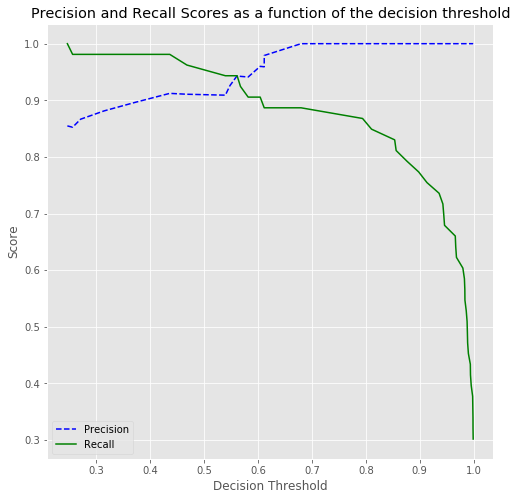

In [66]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    
    
plot_precision_recall_vs_threshold(p, r, thresholds)

0.9943396226415095


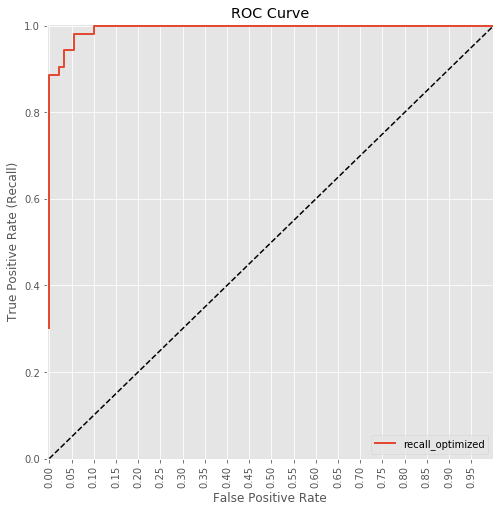

In [67]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')
    
    
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')